In [ ]:
import torch
print(torch.cuda.is_available())  # Deve dar True
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3090


In [ ]:
import accelerate, transformers, torch
print(f"accelerate: {accelerate.__version__}")
print(f"transformers: {transformers.__version__}")
print(f"torch CUDA: {torch.cuda.is_available()}")

accelerate: 0.29.3
transformers: 4.51.3
torch CUDA: True


Import livrarias de transformers

In [ ]:
import pandas as pd
import sklearn
import accelerate
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
import evaluate
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

a) Uso de transformers com o modelo "distilbert-base-uncased-finetuned-sst-2-english" com função de pre processamento

In [ ]:
from transformers import pipeline
import pandas as pd
import re
import torch

# Carregar dados
df = pd.read_csv('imdb_reviews_test.csv')

# Remover duplicados apenas do dataset de teste
df = df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# Função para limpar apenas tags HTML e URLs
def clean_text(text):
    # Remover tags HTML
    text = re.sub(r'<.*?>', ' ', text)
    # Remover URLs (http, https, www)
    text = re.sub(r'http[s]?://\S+', ' ', text)
    text = re.sub(r'www\.\S+', ' ', text)
    # Remover espaços extras e normalizar
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar limpeza ao texto
df['text'] = df['text'].apply(clean_text)

# Extrair textos e labels para uso com o pipeline
texts = df['text'].tolist()
true_labels = df['label'].tolist()

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline(
    "sentiment-analysis",
    model=model_name,
    device=0 if torch.cuda.is_available() else -1,
    batch_size=16
)

preds = classifier(texts, batch_size=16, truncation=True)
pred_labels = ["pos" if p['label'] == "POSITIVE" else "neg" for p in preds]

accuracy = sum(p == t for p, t in zip(pred_labels, true_labels)) / len(true_labels)
print(f"{model_name}: {accuracy:.4f}")

Device set to use cuda:0


distilbert-base-uncased-finetuned-sst-2-english: 0.9006


a) Uso da alternativo ao modelo anterior, agora com "textattack/bert-base-uncased-imdb" com função de pre processamento

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import re
import torch

# Carregar dados
df = pd.read_csv('imdb_reviews_test.csv')

# Remover duplicados apenas do dataset de teste
df = df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# Função para limpar apenas tags HTML e URLs
def clean_text(text):
    # Remover tags HTML
    text = re.sub(r'<.*?>', ' ', text)
    # Remover URLs (http, https, www)
    text = re.sub(r'http[s]?://\S+', ' ', text)
    text = re.sub(r'www\.\S+', ' ', text)
    # Remover espaços extras e normalizar
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar limpeza ao texto
df['text'] = df['text'].apply(clean_text)

# Extrair textos e labels para uso com o pipeline
texts = df['text'].tolist()
true_labels = df['label'].tolist()

# Carregar modelo e tokenizador
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Forçar mapeamento de rótulos
model.config.id2label = {0: "neg", 1: "pos"}
model.config.label2id = {"neg": 0, "pos": 1}

# Pipeline configurado para classificação de texto
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    batch_size=16
)

# Processar previsões
preds = classifier(texts, batch_size=16, truncation=True)
pred_labels = [p['label'] for p in preds]  # Agora retorna 'neg'/'pos'

# Calcular accuracy
accuracy = sum(p == t for p, t in zip(pred_labels, true_labels)) / len(true_labels)
print(f"{model_name}: {accuracy:.4f}")

Device set to use cuda:0


textattack/bert-base-uncased-imdb: 0.9379


b) Uso de transformers com o modelo "distilbert-base-uncased" com função de pre processamento e fine tunning, baseado na proposta a)

Map: 100%|██████████| 21814/21814 [00:07<00:00, 2897.84 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\baron\AppData\Local\Temp\ipykernel_29900\2939956131.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.205000,0.187278,0.928349,0.928115
2,0.152600,0.173571,0.935729,0.935087
3,0.097200,0.225786,0.933987,0.932817
4,0.057400,0.255917,0.936738,0.936917
5,0.038700,0.261455,0.936188,0.936905
6,0.037200,0.317536,0.935225,0.934544
7,0.007000,0.391135,0.935592,0.935292
8,0.013300,0.401367,0.934492,0.935307
9,0.006000,0.410593,0.936050,0.936362
10,0.005100,0.411728,0.937013,0.937059


Resultados finais: {'eval_loss': 0.17357106506824493, 'eval_accuracy': 0.9357293481250573, 'eval_f1': 0.9350865820909343, 'eval_runtime': 36.7798, 'eval_samples_per_second': 593.097, 'eval_steps_per_second': 9.271, 'epoch': 10.0}
A calcular accuracy no conjunto de treino...
Accuracy no treino: 0.9818


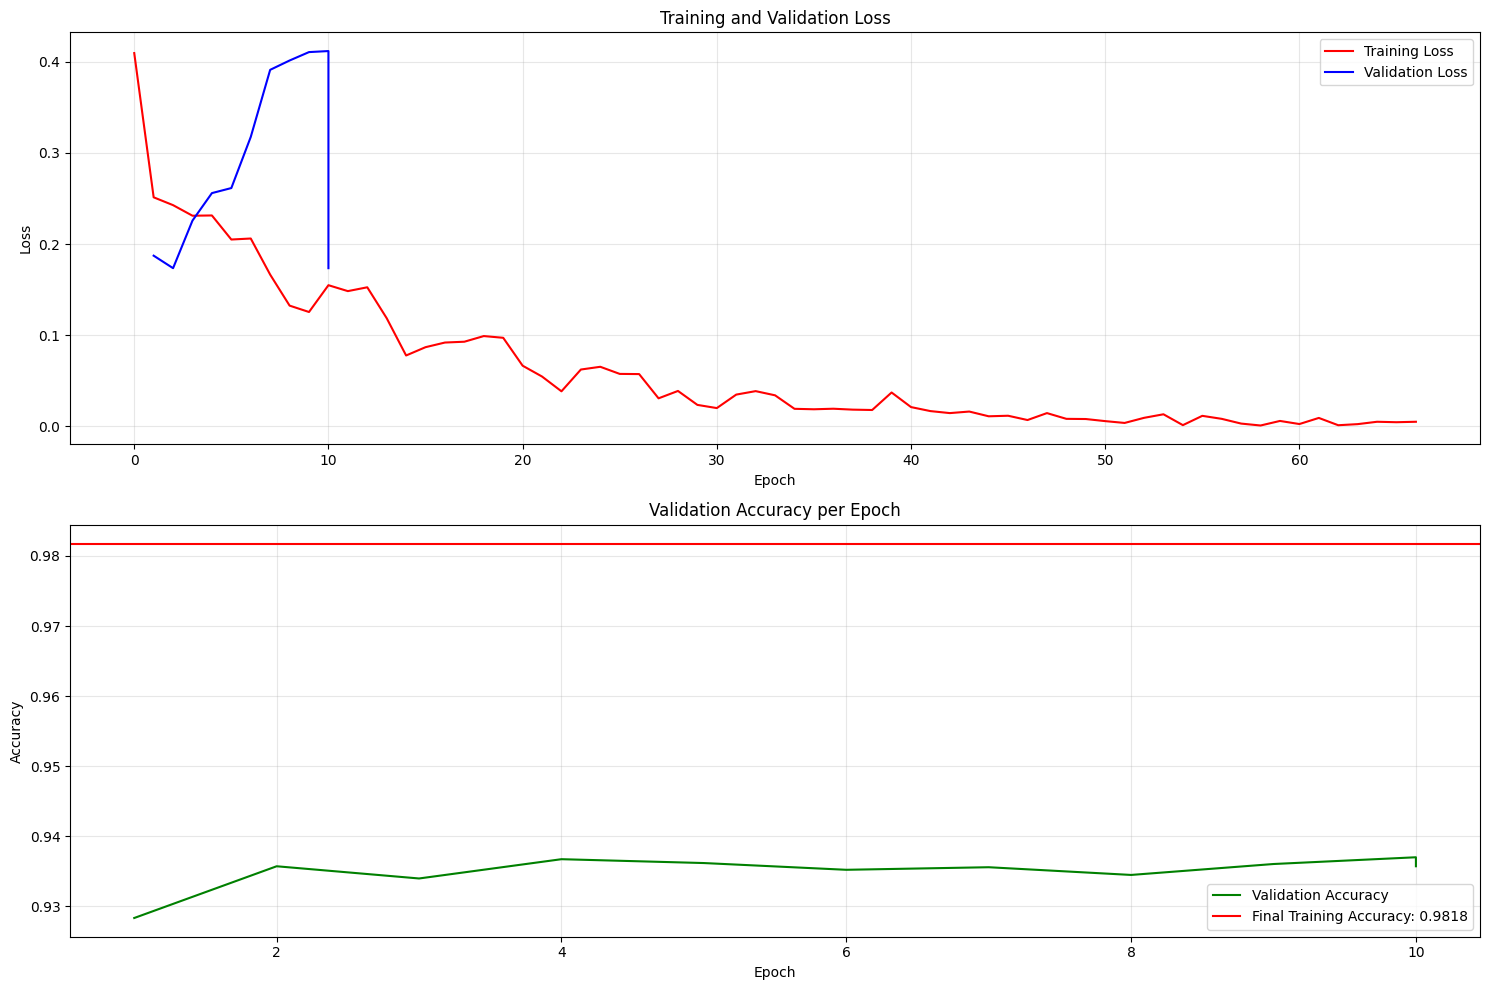

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
import re
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Remover duplicados
train_df = train_df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)
test_df = test_df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# Função para limpar apenas tags HTML e URLs
def clean_text(text):
    # Remover tags HTML
    text = re.sub(r'<.*?>', ' ', text)
    # Remover URLs (http, https, www)
    text = re.sub(r'http[s]?://\S+', ' ', text)
    text = re.sub(r'www\.\S+', ' ', text)
    # Remover espaços extras e normalizar
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Converter para Dataset e preparar dados com limpeza
def prepare_dataset_with_cleaning(df):
    # Aplicar limpeza ao texto
    df['text'] = df['text'].apply(clean_text)

    # Criar dataset
    dataset = Dataset.from_pandas(df[['text', 'label']])

    # Converter labels para formato numérico
    dataset = dataset.map(lambda x: {
        'label': 1 if x['label'] == 'pos' else 0
    })
    return dataset

# Preparar datasets com limpeza
train_dataset = prepare_dataset_with_cleaning(train_df)
test_dataset = prepare_dataset_with_cleaning(test_df)

# Tokenização
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding='max_length'
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Configurar Modelo
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # positive/negative
)

# Avaliação
def compute_metrics(eval_pred):
    metric_accuracy = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=predictions, references=labels)["f1"]
    }

# Configurar Treino
training_args = TrainingArguments(
    output_dir="imdb_sentiment_model",
    per_device_train_batch_size=32,  # Aumentado para RTX 3090
    per_device_eval_batch_size=64,   # Aumentado para RTX 3090
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=100,
    eval_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,  # Ativar mixed precision para melhor desempenho
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Treinar
training_history = trainer.train()

# Avaliação final
results = trainer.evaluate()
print(f"Resultados finais: {results}")

# Extrair dados de loss e accuracy por epoch
epochs = []
train_loss = []
eval_loss = []
eval_accuracy = []

for entry in trainer.state.log_history:
    if 'epoch' in entry and 'eval_loss' in entry:
        epochs.append(entry['epoch'])
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
    elif 'loss' in entry and 'eval_loss' not in entry:
        train_loss.append(entry['loss'])

# Calcular accuracy no conjunto de treino (após o treino)
train_results = trainer.predict(tokenized_train)
train_preds = np.argmax(train_results.predictions, axis=1)
train_labels = train_results.label_ids
train_accuracy = (train_preds == train_labels).mean()
print(f"Accuracy no treino: {train_accuracy:.4f}")

b) Uso de transformers com o modelo "roberta-base" com função de pre processamento e fine tunning, baseado na proposta a)

In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import evaluate

# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Converter para Dataset e preparar dados
def prepare_dataset(df):
    dataset = Dataset.from_pandas(df[['text', 'label']])
    # Converter labels para formato numérico
    dataset = dataset.map(lambda x: {
        'label': 1 if x['label'] == 'pos' else 0
    })
    return dataset

train_dataset = prepare_dataset(train_df)
test_dataset = prepare_dataset(test_df)

# Tokenização com RoBERTa
modelo_base = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(modelo_base)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Configurar para classificação binária
model = AutoModelForSequenceClassification.from_pretrained(
    modelo_base,
    num_labels=2
)

# Função para métricas
def compute_metrics(eval_pred):
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

# Configurar treino
training_args = TrainingArguments(
    output_dir="./imdb_sentiment_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Inicializar trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Treinar o modelo (fine-tuning)
trainer.train()

# Avaliar o modelo
results = trainer.evaluate()
print(f"Resultados da avaliação: {results}")

# Salvar o modelo fine-tuned
trainer.save_model("./imdb_sentiment_final")

# Exemplo de como usar o modelo para previsões
from transformers import pipeline

# Carregar o modelo fine-tuned
classifier = pipeline("sentiment-analysis", model="./imdb_sentiment_final", tokenizer=tokenizer)

# Exemplo de previsão
exemplo = "This movie was fantastic! I really enjoyed the plot and the acting was superb."
resultado = classifier(exemplo)
print(f"Texto: {exemplo}")
print(f"Sentimento: {resultado}")


Map: 100%|██████████| 21996/21996 [00:02<00:00, 7471.38 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\baron\AppData\Local\Temp\ipykernel_29900\1730400459.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.265300,0.223944,0.945217,0.944262
2,0.188500,0.235413,0.948627,0.949067
3,0.107000,0.271283,0.948263,0.949124
4,0.062400,0.289810,0.949309,0.949210
5,0.035300,0.340945,0.948627,0.947854
6,0.022100,0.365526,0.950718,0.949940
7,0.030800,0.332864,0.952264,0.952617
8,0.013400,0.344007,0.952264,0.952173
9,0.005800,0.378163,0.952673,0.952800
10,0.004300,0.372450,0.953355,0.953151


Avaliando o modelo...


Resultados da avaliação: {'eval_loss': 0.3724499046802521, 'eval_accuracy': 0.953355155482815, 'eval_f1': 0.9531506849315069, 'eval_runtime': 105.9131, 'eval_samples_per_second': 207.68, 'eval_steps_per_second': 12.982, 'epoch': 10.0}


Device set to use cuda:0


Modelo salvo com sucesso!
Texto: This movie was fantastic! I really enjoyed the plot and the acting was superb.
Sentimento: [{'label': 'LABEL_1', 'score': 0.9998451471328735}]


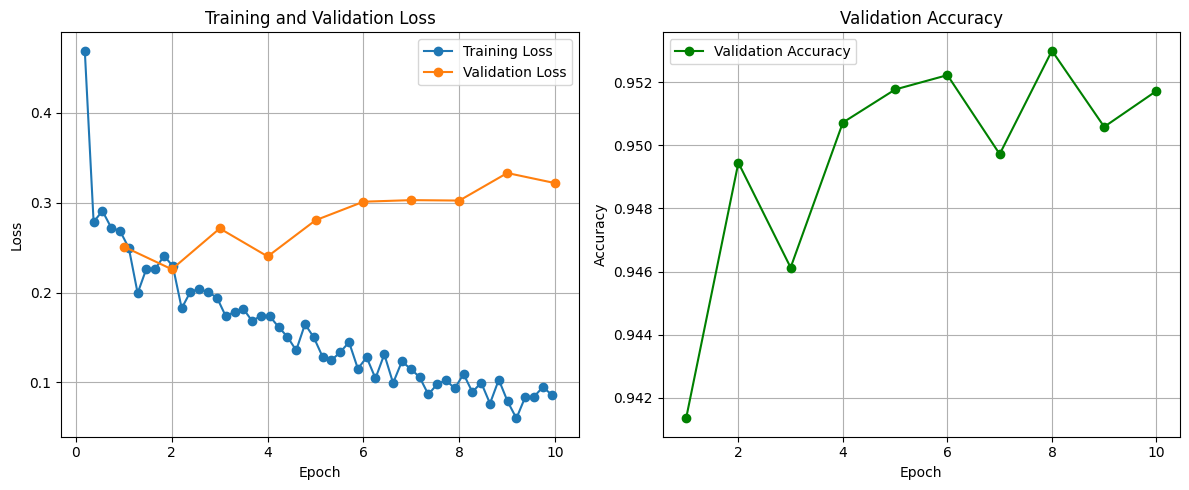

Arquivo trainer_state.json não encontrado no diretório especificado.


In [ ]:
import json
import matplotlib.pyplot as plt

# Caminho para o trainer_state.json no último checkpoint
with open('./imdb_sentiment_model/checkpoint-27200/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

    logs = trainer_state.get('log_history', [])

    train_loss = []
    eval_loss = []
    eval_accuracy = []
    epochs_train = []
    epochs_eval = []

    for entry in logs:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            epochs_train.append(entry['epoch'])
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
            epochs_eval.append(entry['epoch'])
        if 'eval_accuracy' in entry:
            eval_accuracy.append(entry['eval_accuracy'])

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_train, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs_eval, eval_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_eval, eval_accuracy, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Plotar os gráficos após o treinamento
plot_training_metrics()


Procurar exemplos de falsos positivos e negativos

In [ ]:
# para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

# Índices dos falsos positivos e negativos
# Assumindo que 1 = positivo e 0 = negativo
falsos_positivos_idx = np.where((predictions == 1) & (y_test == 0))[0]
falsos_negativos_idx = np.where((predictions == 0) & (y_test == 1))[0]

# Selecionar exemplos com ambas as colunas
falsos_positivos_exemplos = test_df.iloc[falsos_positivos_idx[:20]][['text', 'processed_text', 'label']]
falsos_negativos_exemplos = test_df.iloc[falsos_negativos_idx[:20]][['text', 'processed_text', 'label']]

# Adicionar a probabilidade de cada previsão para análise
if hasattr(model, 'predict_proba'):
    probs = model.predict_proba(X_test)
    # Adicionar probabilidades aos exemplos de falsos positivos
    for i, idx in enumerate(falsos_positivos_idx[:20]):
        prob = probs[idx][1]
        falsos_positivos_exemplos.loc[falsos_positivos_exemplos.index[i], 'confidence'] = prob

    # Adicionar probabilidades aos exemplos de falsos negativos
    for i, idx in enumerate(falsos_negativos_idx[:20]):
        prob = probs[idx][1]
        falsos_negativos_exemplos.loc[falsos_negativos_exemplos.index[i], 'confidence'] = prob

# Exibir os resultados
print(f"Total de Falsos Positivos: {len(falsos_positivos_idx)}")
print(f"Total de Falsos Negativos: {len(falsos_negativos_idx)}")

print("\n=== FALSOS POSITIVOS (classificados como positivos, mas são negativos) ===")
print(falsos_positivos_exemplos)

print("\n=== FALSOS NEGATIVOS (classificados como negativos, mas são positivos) ===")
print(falsos_negativos_exemplos)

# palavras mais comuns nos erros
from collections import Counter
import re

def extract_words(texts):
    all_words = []
    for text in texts:
        # Extrair palavras (remover pontuação e converter para minúsculas)
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    return all_words

Total de Falsos Positivos: 1862
Total de Falsos Negativos: 2043

=== FALSOS POSITIVOS (classificados como positivos, mas são negativos) ===
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

b) Uso de transformers com o modelo "roberta-base" com função de pre processamento e fine tunning, baseado na proposta com 8 epochs

In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import evaluate
import re
import matplotlib.pyplot as plt
import json
import os

# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Remover duplicados
train_df = train_df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)
test_df = test_df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# Função para limpar apenas tags HTML e URLs
def clean_text(text):
    # Remover tags HTML
    text = re.sub(r'<.*?>', ' ', text)
    # Remover URLs (http, https, www)
    text = re.sub(r'http[s]?://\S+', ' ', text)
    text = re.sub(r'www\.\S+', ' ', text)
    # Remover espaços extras e normalizar
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Converter para Dataset e preparar dados com limpeza
def prepare_dataset_with_cleaning(df):
    # Aplicar limpeza ao texto
    df['text'] = df['text'].apply(clean_text)
    # Criar dataset
    dataset = Dataset.from_pandas(df[['text', 'label']])
    # Converter labels para formato numérico
    dataset = dataset.map(lambda x: {
        'label': 1 if x['label'] == 'pos' else 0
    })
    return dataset

# Preparar datasets com limpeza
train_dataset = prepare_dataset_with_cleaning(train_df)
test_dataset = prepare_dataset_with_cleaning(test_df)

# Tokenização usando RoBERTa
modelo_base = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(modelo_base)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Configurar modelo para classificação binária
model = AutoModelForSequenceClassification.from_pretrained(
    modelo_base,
    num_labels=2
)

# Função para métricas
def compute_metrics(eval_pred):
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

# Configurar treino
training_args = TrainingArguments(
    output_dir="./imdb_sentiment_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    optim="adamw_torch",
    metric_for_best_model="accuracy",
)

# Inicializar trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Treinar o modelo (fine-tuning)
trainer.train()

# Avaliar o modelo
results = trainer.evaluate()
print(f"Resultados da avaliação: {results}")

Map: 100%|██████████| 21996/21996 [00:02<00:00, 8894.06 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\baron\AppData\Local\Temp\ipykernel_29900\810617410.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.238300,0.168930,0.948900,0.948402
2,0.185400,0.211084,0.952673,0.953004
3,0.106900,0.240526,0.952673,0.952800
4,0.048100,0.247457,0.952400,0.952346
5,0.033500,0.364082,0.948945,0.948304
6,0.013600,0.360860,0.953310,0.953409
7,0.017400,0.365272,0.952310,0.951901
8,0.013800,0.366653,0.953173,0.953237


Avaliando o modelo...


Resultados da avaliação: {'eval_loss': 0.3608599603176117, 'eval_accuracy': 0.9533096926713948, 'eval_f1': 0.9534092455654857, 'eval_runtime': 77.5514, 'eval_samples_per_second': 283.631, 'eval_steps_per_second': 17.73, 'epoch': 8.0}


In [ ]:
# Calcular accuracy no conjunto de treino
results_train = trainer.predict(tokenized_train)
predictions_train = np.argmax(results_train.predictions, axis=1)
true_train = [ex['label'] for ex in train_dataset]
accuracy_metric = evaluate.load("accuracy")
train_acc = accuracy_metric.compute(predictions=predictions_train, references=true_train)["accuracy"]
print(f"Accuracy no treino: {train_acc:.4f}")

Calculando accuracy no conjunto de treino...
Accuracy no treino: 0.9990


In [ ]:
training_logs = trainer.state.log_history
print(training_logs)

[{'loss': 0.3665, 'grad_norm': 5.250872611999512, 'learning_rate': 4.909375000000001e-06, 'epoch': 0.18382352941176472, 'step': 500}, {'loss': 0.286, 'grad_norm': 0.22540540993213654, 'learning_rate': 4.817463235294118e-06, 'epoch': 0.36764705882352944, 'step': 1000}, {'loss': 0.2766, 'grad_norm': 108.25299835205078, 'learning_rate': 4.725551470588235e-06, 'epoch': 0.5514705882352942, 'step': 1500}, {'loss': 0.2576, 'grad_norm': 0.2971356511116028, 'learning_rate': 4.633639705882354e-06, 'epoch': 0.7352941176470589, 'step': 2000}, {'loss': 0.246, 'grad_norm': 0.0706309974193573, 'learning_rate': 4.5417279411764705e-06, 'epoch': 0.9191176470588235, 'step': 2500}, {'eval_loss': 0.2592562735080719, 'eval_accuracy': 0.9364884524458993, 'eval_f1': 0.9388434093595412, 'eval_runtime': 79.0144, 'eval_samples_per_second': 278.38, 'eval_steps_per_second': 17.402, 'epoch': 1.0, 'step': 2720}, {'loss': 0.2311, 'grad_norm': 0.06581835448741913, 'learning_rate': 4.450000000000001e-06, 'epoch': 1.102

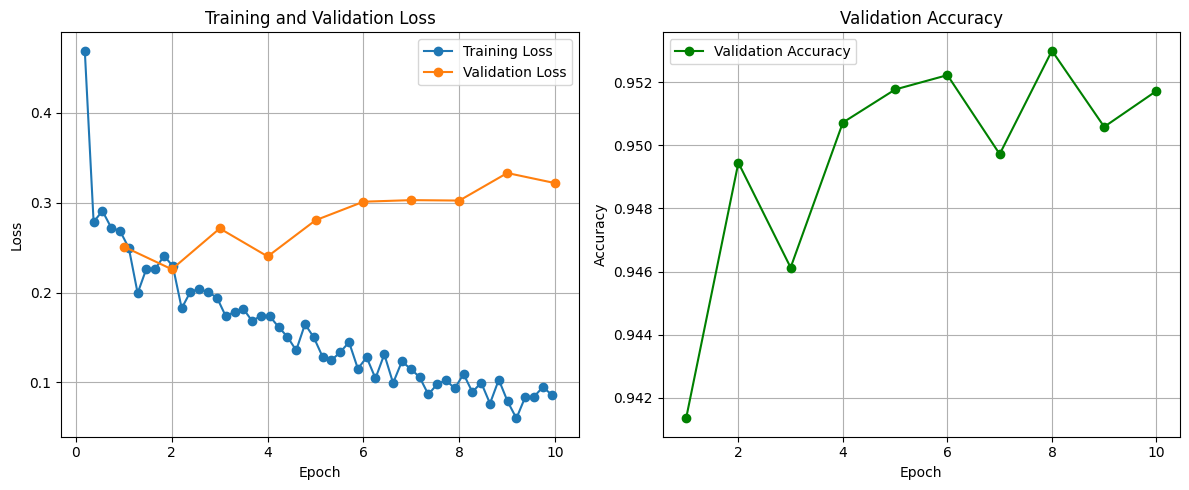

Arquivo trainer_state.json não encontrado no diretório especificado.


In [ ]:
import json
import matplotlib.pyplot as plt

# Caminho
with open('./imdb_sentiment_model/checkpoint-27200/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

    logs = trainer_state.get('log_history', [])

    train_loss = []
    eval_loss = []
    eval_accuracy = []
    epochs_train = []
    epochs_eval = []

    for entry in logs:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            epochs_train.append(entry['epoch'])
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
            epochs_eval.append(entry['epoch'])
        if 'eval_accuracy' in entry:
            eval_accuracy.append(entry['eval_accuracy'])

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_train, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs_eval, eval_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_eval, eval_accuracy, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Chamar a função para plotar os gráficos
plot_training_metrics()



Gerando matriz de confusão...


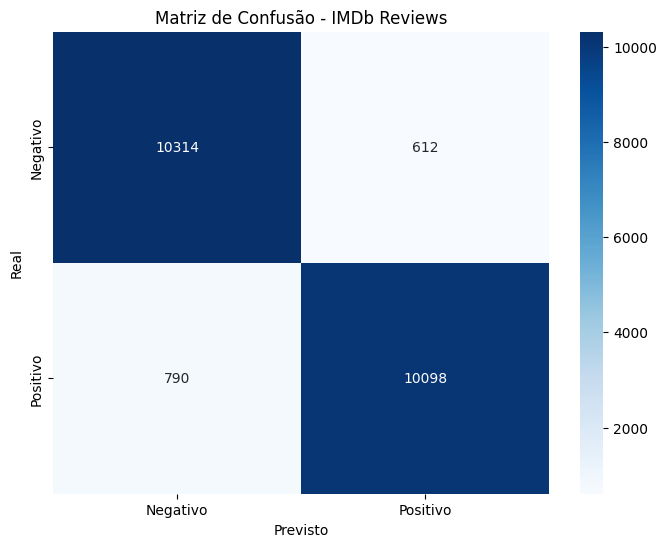

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obter previsões
predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Obter labels
true_labels = test_dataset['label']

# Calcular matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão - IMDb Reviews')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()
